In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd


import geoplot.crs as gcrs
import geoplot as gplt
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns

import os,glob,sys

In [2]:
plt.style.use("bmh")

# Data Wrangling

In [3]:
data = pd.read_csv("../data/Train.csv", parse_dates=["date"])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121653 entries, 0 to 121652
Data columns (total 62 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 121653 non-null  object        
 1   date               121653 non-null  datetime64[ns]
 2   lat                121653 non-null  float64       
 3   lng                121653 non-null  float64       
 4   temperature        121653 non-null  float64       
 5   precipitation      121252 non-null  float64       
 6   humidity           121612 non-null  float64       
 7   global_radiation   121252 non-null  float64       
 8   hydrometric_level  121653 non-null  float64       
 9   N                  121293 non-null  float64       
 10  NE                 121293 non-null  float64       
 11  E                  121293 non-null  float64       
 12  SE                 121293 non-null  float64       
 13  S                  121293 non-null  float64 

## Stations ID

In [5]:
# Generate unique station ID 
data["stn_ID"] = (np.floor(data.lat*100) * 100000 + np.floor(data.lng*1000)).astype("int")

## Dublicates

In [6]:
dublicate_sample = data[(data.type == "NS") & (data.date == "2016-01-01") & (data.lat == 45.496780)]
print(dublicate_sample.iloc[0,4], dublicate_sample.iloc[1,4])

1.5363636363636364 1.5363636363636362


In [7]:
# Drop object columns with UTM coordinates
data.drop(["ID","utm_x","utm_y", "type"],axis=1,inplace=True)

# Check for duolicates
print(f"Number of the duplicated columns: {data.round(6).duplicated().sum()}")

Number of the duplicated columns: 26790


In [8]:
# Drop duplicates
data = data.round(6)
data.drop_duplicates(inplace=True)

## Missing Data

In [9]:
# List columns with null values
columns_with_null = data.columns[data.isnull().any()]

# Display the columns with null values
print("\nColumns with Null Values:")
print(data[columns_with_null].isna().sum())


Columns with Null Values:
precipitation        401
humidity              41
global_radiation     401
N                    360
NE                   360
E                    360
SE                   360
S                    360
SW                   360
W                    360
NW                   360
pm25                1036
pm10                 328
dtype: int64


In [10]:
data.dropna(inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93466 entries, 0 to 121652
Data columns (total 59 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               93466 non-null  datetime64[ns]
 1   lat                93466 non-null  float64       
 2   lng                93466 non-null  float64       
 3   temperature        93466 non-null  float64       
 4   precipitation      93466 non-null  float64       
 5   humidity           93466 non-null  float64       
 6   global_radiation   93466 non-null  float64       
 7   hydrometric_level  93466 non-null  float64       
 8   N                  93466 non-null  float64       
 9   NE                 93466 non-null  float64       
 10  E                  93466 non-null  float64       
 11  SE                 93466 non-null  float64       
 12  S                  93466 non-null  float64       
 13  SW                 93466 non-null  float64       
 14  W         

In [12]:
data.to_csv("../results/CSVs/Train_clean.csv", index=False)

# Exploratory Data Analysis

In [13]:
data[["pm25", "temperature", "precipitation", "humidity"]].describe()

,pm25,temperature,precipitation,humidity
count,93466.000000,93466.000000,93466.000000,93466.000000
mean,22.571290,14.770707,2.513287,71.430747
std,15.693777,8.182451,7.338255,16.868703
min,0.000000,-7.123913,0.000000,13.604109
25%,11.056499,7.780119,0.000000,58.912232
50%,17.061453,14.585962,0.000000,70.520851
75%,30.018297,22.306578,0.731179,85.551389
max,78.041650,34.202083,169.417273,103.181250


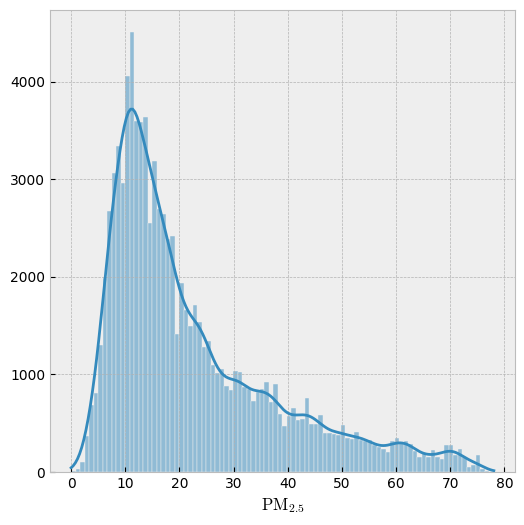

In [14]:
fig, ax = plt.subplots( figsize=(6, 6))
sns.histplot(data['pm25'], kde=True, ax=ax)
ax.set_xlabel("$\mathrm{PM}_{2.5}$")
ax.set_ylabel("")
# ax.set_title('Distribution of $\mathrm{PM}_{2.5}$')
plt.savefig("../results/figures/Distribution_of_PM25", dpi=300,bbox_inches="tight")
plt.show()

In [15]:
data_daily_avg = data.groupby("date").mean()
data_daily_avg["day_of_year"] = data_daily_avg.index.dayofyear
data_daily_avg["day_of_month"] = data_daily_avg.index.day
data_daily_avg["month"] = data_daily_avg.index.month
data_daily_avg["day_of_week"] = data_daily_avg.index.dayofweek
data_daily_avg["week_of_year"] = data_daily_avg.index.isocalendar().week
data_daily_avg["date"] = data_daily_avg.index.year
# data_monthly_avg = data_daily_avg.resample("M").mean()

## Daily seasonality

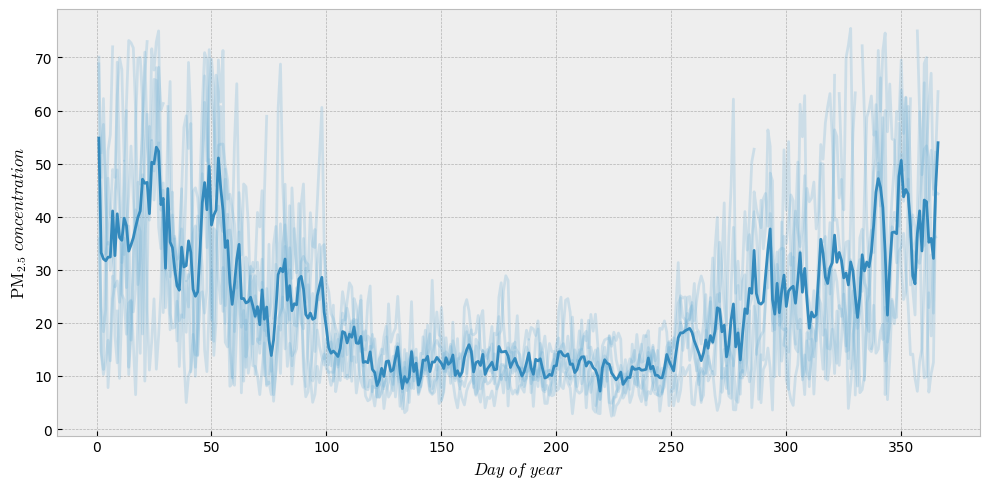

In [16]:
var = "pm25"
cmap = sns.color_palette("Blues", n_colors=5)
fig, ax = plt.subplots(figsize=[10, 5])

(
    data_daily_avg.pivot(index=["day_of_year"], columns=["date"])[var].plot(
        legend=False, alpha=0.25, color=cmap[2], ax=ax
    )
)

(data_daily_avg.groupby("day_of_year").mean(numeric_only=True)[var].plot(ax=ax))

plt.ylabel("$\\mathrm{PM}_{2.5}\ concentration$")
ax.set_xlabel("$Day\ of\ year$")

plt.tight_layout()
plt.savefig("../results/figures/yearly_pm25", dpi=300,bbox_inches="tight")

plt.show()

## Weekly seasonality

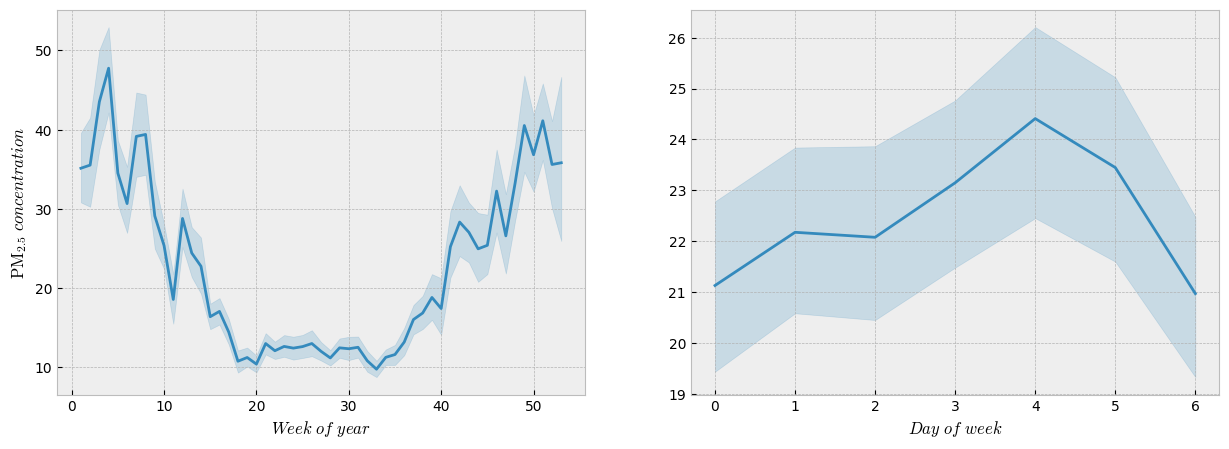

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=[15, 5])

sns.lineplot(data=data_daily_avg, y="pm25", x="week_of_year",ax=ax[0])
sns.lineplot(data=data_daily_avg, y="pm25", x="day_of_week",ax=ax[1])

ax[0].set_ylabel("$\\mathrm{PM}_{2.5}\ concentration$")
ax[0].set_xlabel("$Week\ of\ year$")
ax[1].set_xlabel("$Day\ of\ week$")
ax[1].set_ylabel("")

plt.savefig("../results/figures/weekly_seasonality_of_pm25", dpi=300,bbox_inches="tight")
plt.show()

## Yearly seasonality

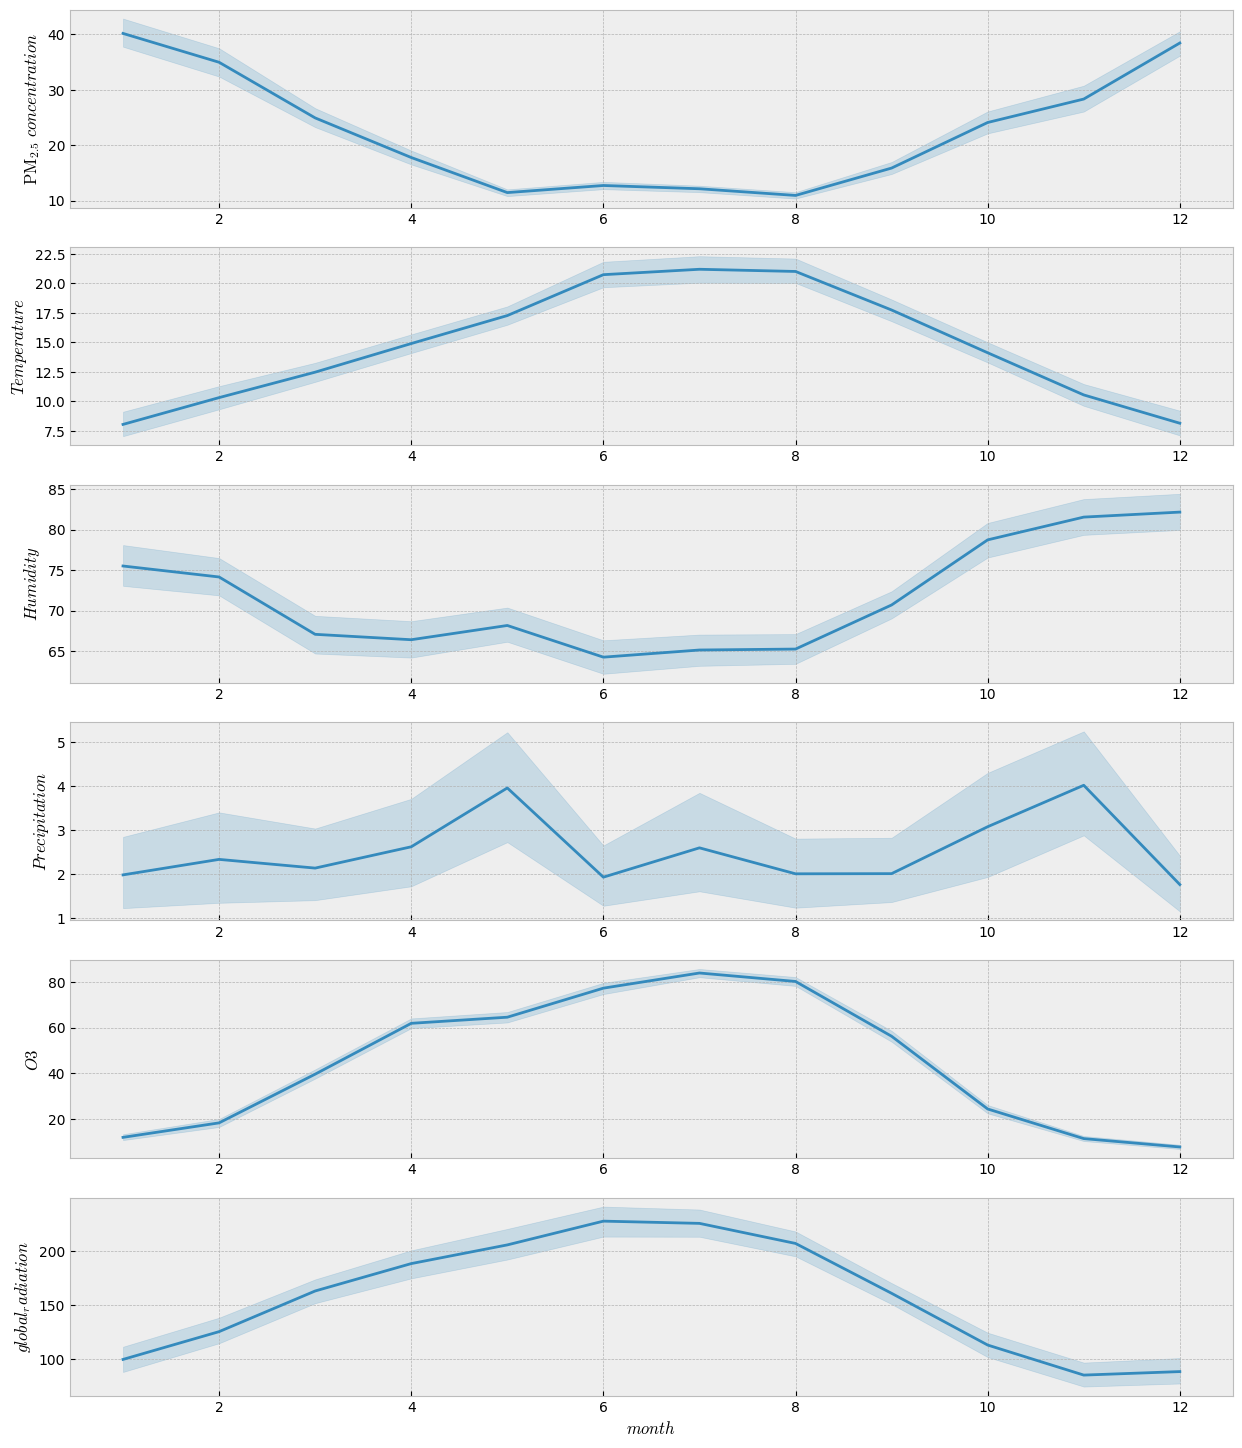

In [25]:
fig, ax = plt.subplots(nrows=6, figsize=[15, 18])
sns.lineplot(data=data_daily_avg, y="pm25", x="month",ax=ax[0])

ax[0].set_ylabel("$\\mathrm{PM}_{2.5}\ concentration$")
ax[0].set_xlabel("")


sns.lineplot(data=data_daily_avg, y="temperature", x="month",ax=ax[1])

ax[1].set_ylabel("$Temperature$")
ax[1].set_xlabel("")

sns.lineplot(data=data_daily_avg, y="humidity", x="month",ax=ax[2])

ax[2].set_ylabel("$Humidity$")
ax[2].set_xlabel("")

sns.lineplot(data=data_daily_avg, y="precipitation", x="month",ax=ax[3])

ax[3].set_ylabel("$Precipitation$")
ax[3].set_xlabel("")


sns.lineplot(data=data_daily_avg, y="o3", x="month",ax=ax[4])

ax[4].set_ylabel("$O3$")
ax[4].set_xlabel("")


sns.lineplot(data=data_daily_avg, y="global_radiation", x="month",ax=ax[5])

ax[5].set_ylabel("$global_radiation$")
ax[5].set_xlabel("$month$")

plt.savefig("../results/figures/yearly_seasonality", dpi=300,bbox_inches="tight")
plt.show()

In [19]:
average_pm25_stations = data.groupby(['lat', 'lng'])['pm25'].mean().reset_index()
stations = gpd.GeoDataFrame(average_pm25_stations,geometry=gpd.points_from_xy(average_pm25_stations.lng, average_pm25_stations.lat, crs=4326))

In [20]:
print(f"Number of the stations is: {stations.shape}")

Number of the stations is: (55, 4)


In [21]:
metropolitan_city_of_Milan = gpd.read_file("../data/metropolitan_city_of_Milan.geojson")
italy_cities = gpd.read_file("../data/ITA_adm3.geojson")

In [22]:
cities_in_metropolitan = italy_cities.sjoin(metropolitan_city_of_Milan, how="inner", predicate="intersects")
stations_in_metropolitan_city_of_Milan = gpd.sjoin(stations,metropolitan_city_of_Milan, how='inner',predicate='intersects')

ConnectionError: HTTPSConnectionPool(host='tile.openstreetmap.org', port=443): Max retries exceeded with url: /10/536/365.png (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fcf9f3ffa90>: Failed to establish a new connection: [Errno 101] Network is unreachable'))

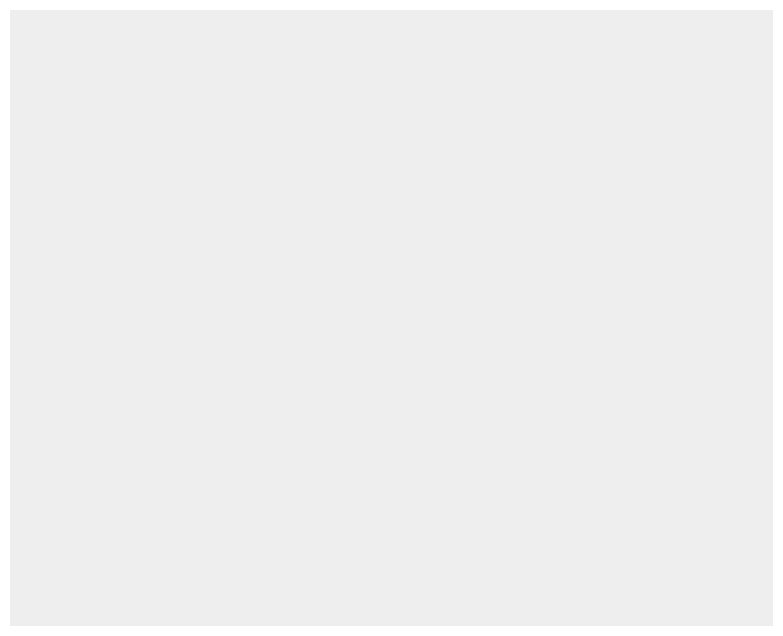

In [26]:
ax = gplt.webmap(stations,projection=gcrs.WebMercator(),figsize=(10, 8))
ax = gplt.polyplot(metropolitan_city_of_Milan,edgecolor="blue",ax=ax)
gplt.pointplot(stations_in_metropolitan_city_of_Milan,ax=ax, color="red")

plt.savefig("../results/figures/measurment_stations", dpi=300,bbox_inches="tight")
plt.show()

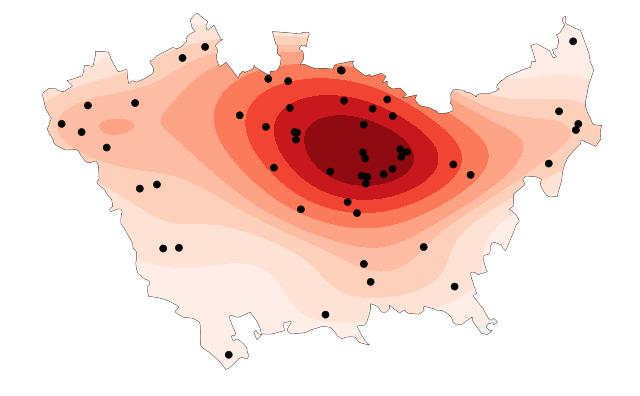

In [27]:
ax = gplt.kdeplot(
    stations_in_metropolitan_city_of_Milan,fill=True, cmap='Reds',
    clip=metropolitan_city_of_Milan.geometry,
    projection=gcrs.WebMercator())
# # Plotting the heatmap on top of the boroughs for context
gplt.polyplot(metropolitan_city_of_Milan, ax=ax, zorder=1)
gplt.pointplot(stations_in_metropolitan_city_of_Milan,ax=ax, color="black")

plt.savefig("../results/figures/spatial_distribution_of_stations", dpi=300,bbox_inches="tight")
plt.show()

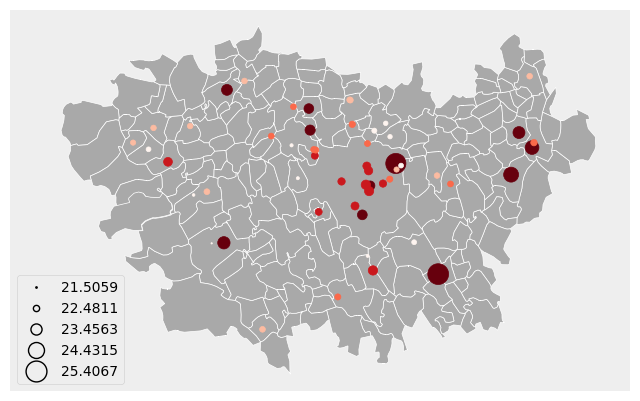

In [28]:
ax = gplt.polyplot(
    cities_in_metropolitan, projection=gcrs.AlbersEqualArea(),
    edgecolor='white', facecolor='darkgray',
    figsize=(8, 6)
)

gplt.pointplot(
    stations_in_metropolitan_city_of_Milan, ax=ax, hue='pm25', cmap='Reds',
    scheme='quantiles',
    limits=(1, 15),
    scale='pm25',
    legend=True, legend_var='scale',
    legend_kwargs={'frameon': True, "loc": "lower left"},
    extent=(8.5,45.2,9.7,45.7)
)
plt.savefig("../results/figures/spatial_distribution_of_pm25", dpi=300,bbox_inches="tight")
plt.show()